# Face Recognition #11

- We are using: Ubble dataset

We have used during the computation of the FAR and TAR only the encodings that have been previously generated in order to speed up the execution.
Each person is described by a vector that contains a certain number of  encodings generated from images among all the ones available for a certain person in a video.


##Basic import

Needed for Google colab in order to mount the local filesystem

In [0]:
import sys
import os
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/PRIM/'  # your new root path

sys.path.append(os.path.join(root_path, 'notebooks')) # for importing from utils.py

# install the face_recognition package used in the whole code
!pip install face_recognition

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pickle # to save and retrieve encodings and data
import cv2 #
from imutils import paths
import face_recognition
import argparse
import cv2
import dlib#face_recognition is based on dlib the compiled version for gpu is preferred
import matplotlib.pyplot as plt
import time
import pdb #debug
import numpy as np
import random
import csv


#return true if the gpu is enabled
print(dlib.DLIB_USE_CUDA)

True


In [0]:
#os.listdir(root_path + 'face_videos/face_videos')

## Creating new encodings & boxes

In [0]:
def createEncodings(dataset_vector, name , detection = 'cnn'):

    '''
    - dataset_vector: array of images that represent the video
    - name: name of the person of which we're going to create the encodings
    - detection: parameter to be passed to face_recognition, it specify the model used to retrieve boxes from images

    - return: None, all the encodings are saved on the disk
    '''

    # grab the paths to the input images in our dataset
    print("[INFO] quantifying faces...")
    '''
    We're going to take all the images and create the encodings
    '''

    #if the vector doesn't contin images an error in reported
    if len(dataset_vector )<= 0:
      print("AN ERROR OCCURRED FOR ",name)
      return

    images = dataset_vector #create the encodings for each frame in the video --> it will take a lot of time to do all the videos-> 5/6 hours

    # initialize the list of known encodings and known names
    knownEncodings = []
    knownNames = []

    # initialize the list of face area and image area and ratio based on the two preceden measurement
    ratios = []
    face_areas = []
    image_areas = []
    landmarks = []
        
    # loop over the image paths
    for image in images:

        # load the input image and convert it from RGB (OpenCV ordering)
        # to dlib ordering (RGB)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #estimate landmark to understand face position
        landmark = face_recognition.face_landmarks(rgb)


        # detect the (x, y)-coordinates of the bounding boxes
        # corresponding to each face in the input image
        #A list of tuples of found face locations in css (top, right, bottom, left) order
        boxes = face_recognition.face_locations(rgb,model=detection)

        ######################### FACE RESOLUTION LOGIC #######################
        
        for face_location in boxes:
            try:
                top, right, bottom, left = face_location #retrieve coords of the face
            except IndexError:
                top = right = bottom = left = 0 #everityin is setted to zero id no face are detected

            #computing the area of the face in the image
            area_face = (bottom-top) * (right-left)
            
            #totale area of the image
            area_image = image.shape[0] * image.shape[1]
            
            #ratio  = area_face/ total_area
            ratio = area_face/area_image * 100

            #add these element to the lists
            ratios.append(ratio)
            face_areas.append(area_face)
            image_areas.append(area_image)
            landmarks.append(landmark)
        #########################
    
        # compute the facial embedding for the face based on the boxes found previously--> face_recognion package
        #Given an image, return the 128-dimension face encoding for each face in the image.
        encodings = face_recognition.face_encodings(rgb, boxes)

        # loop over the encodings
        for encoding in encodings:
            # add each encoding + name to our set of known names and encodings
            knownEncodings.append(encoding)
            knownNames.append(name)
            
    # dump the facial encodings + names to disk
    #everything is saved as a dictionary (names, encoding)
    #the values are the two lists
    print("[INFO] serializing encodings..." + name)
    data = {"encodings": knownEncodings, "names": knownNames}
    file_name = root_path + "/encodings_face_videos_half/" + name + '.pkl'
    
    print(len(knownEncodings))

    f = open(file_name, "wb")
    f.write(pickle.dumps(data))
    f.close()

    
    #-------------------------------------------------------------------#
    #also in the form of dictionary
    boxfile = open(root_path + "/boxes/box_" + name + ".pkl", "wb")
    boxdata = {"ratio": ratios, "face": face_areas, "image": image_areas, "landmark": landmarks}
    boxfile.write(pickle.dumps(boxdata))
    boxfile.close()

### Using CV library crates an array of images sequentially taken from  the video

In [0]:
def readFrames(path):
  '''
  path: absolute/relative path of the video 

  return: a list of images 
  '''
  
  video = cv2.VideoCapture(path)
  frames = []
  while(1):
      ret, frame = video.read()
      if ret == True:
        frames.append(frame)
      else:
          break
  return frames

In [0]:
base_video_path = root_path + 'face_videos/face_videos/'# folder in which all the videos are contained

#run the following code only once, and when you need to genrate the encoding
'''
videos = os.listdir(base_video_path)
global_start = time.time()
count = 0
for video_name in videos:
  start = time.time()
  #frames = readFrames(base_video_path + video_name)#remove the comment if you neeed to train new encodings
  #frames = frames[0:int(len(frames)/2)]#change this if you want to take only part of the total frames
  #createEncodings(frames,video_name)
  end = time.time()
  print('Time_enc:', end-start)
  print(count)
  count += 1

global_end = time.time()
print('Total time:', global_end-global_start)
'''

"\nvideos = os.listdir(base_video_path)\nglobal_start = time.time()\ncount = 0\nfor video_name in videos:\n  start = time.time()\n  #frames = readFrames(base_video_path + video_name)#remove the comment if you neeed to train new encodings\n  #frames = frames[0:int(len(frames)/2)]#change this if you want to take only part of the total frames\n  #createEncodings(frames,video_name)\n  end = time.time()\n  print('Time_enc:', end-start)\n  print(count)\n  count += 1\n\nglobal_end = time.time()\nprint('Total time:', global_end-global_start)\n"

## Code for test

#### Compare a new encoding with all the ones previously saved and retruns the names of the person recognised along with the minimum distance found in the comparison 

In [0]:
def faceRecognitionENC(encodings_1, encodings_2, infos, detection='cnn', tolerance = 0.6, min_area = 1):
    '''
    New version it only works with already made encodings
    - encodings_1: SINGLE encoding of the person we want to recognize--> can be the same or not
    - encodings_2: list of encodings of the person of which we know the name--> encoding saved on 'our server'
    - ratio: ratio of the single face crop compared to the whole frame area
    - tolerance = max eculidean distance between two encoding to be recognised as the same
    - min_area = mi area that the face crip MUST have in order to not be discarded


    Returns:
      name:
          - name if the person is recognized
          - discarded if the frames is not good
          - unknown if the distance is greater than tolerance
      
      dist:the min distance between the new face and the one saved if recognized, 1 otherwise
    '''
    start = time.time()


    data = encodings_2# data on our server
    
    # initialize the list of names for each face detected
    dist = 1.0 #distance assigned to non recognized encodings
    names = []
    
    ######################### FACE RESOLUTION LOGIC###################
    ratio = infos[0]
    landmark = infos[1]


    discarded = "discarded"


    
    if (ratio < min_area):
        #discard the picture
        return discarded, dist
    
    if (landmark == 0):
      #total_profile_ = total_profile_ + 1
      #print("W")
      return discarded, dist
    #########################
    
    # attempt to match each encoding to our known encodings
    #global_number_enc : global parameter that allow us to chose the numeber of known encoding on the server to consider in the comparison
    # if it is <0 all the encodings are taken

    if global_number_enc > 0:
      data = data["encodings"][0:global_number_enc]
    else:
      data = data["encodings"]
    
    #Compare a list of face encodings against a candidate encoding to see if they match based on the tolerance parameter
    #Returns:	A list of True/False values indicating which known_face_encodings match the face encoding to check
    matches = face_recognition.compare_faces(data,encodings_1, tolerance= tolerance)
    
    name = "unknown"

    # check to see if we have found a match
    if True in matches:
      #Given a list of face encodings, compare them to a known face encoding and get a euclidean distance for each comparison face. 
      #The distance tells you how similar the faces are.
      face_distances = face_recognition.face_distance(data, encodings_1)
      
      #Choose the known face with the smallest distance to the new face 
      best_match_index = np.argmin(face_distances)

      if matches[best_match_index]:
          name = encodings_2["names"][best_match_index]
          dist = face_distances[best_match_index]

    # update the list of names
    try:
        name = name.split('/')[2]
    except:
        name = name
    names.append(name)
    
    return names, dist
    

In [0]:
def encodingsRead(path):
    ## PAY ATTENTION:: You need to create the encoding for you dataset using encode_face.py
    data = pickle.loads(open(path, "rb").read())
    return data

In [0]:
def boxesRead(path):
    try:
        data = pickle.loads(open(path, "rb").read())
    except FileNotFoundError:
        boxdata= np.ones(100)
        data = {"ratio": boxdata, "face": boxdata, "image": boxdata}
        print("---- Default box construction")
    return data

#### used to find the name of the subject given the name of the video (specific for our dataset)

In [0]:
import json
#code to retrieve the real name starting from the rec name
with open( root_path +'labelled_videos.json') as json_file:
  data = json.load(json_file)

def readTrueName(rec_name):
  
  for real_name in data:
    if rec_name in data[real_name]:
      return real_name
  return "unknown"

####Two types of early stopping:
* we reject the acces (return False) if after $minFrames$ the percentage of times the algorithm returns False is greater than $0.5$
* we grant the acces if the function **makeDecision** return true. This function starting from $minFrames/5$ compare the average distances (or the min) of the encodings till that moment and make a decison taking into account the number of frames alredy received. 

In [0]:
def makeDecision(distances,threshold,n_frames,min_frames_to_compare, mod = 'avg'):
  '''
  - distances: list of all the face distances so far
  - threshold: percentage of frames to be recognised to say True when distances don't works
  - n_frames: current frame number
  - mod : avg or min , takes the average or the minimum of the distances in order to give the answer
  - Return: True/false to say if the two people are the same
  '''


  if len(distances)>0:
      if  mod == 'avg':
        min_d = np.mean(distances)
      else:
        if mod == 'min':
          min_d = np.amin(distances)
        else:
          print('Only avg or min supperted the default will be used')
          min_d = np.mean(distances)

      dists = np.linspace(0.2, 0.45,50)
      frames = np.linspace(int(min_frames_to_compare/5), min_frames_to_compare*2,50)

      '''
      HAND-MADE VARIANT to explain how it ideally works
      if min_d <= 0.2:
        return True
      if min_d <= 0.25 and len(distances)>=(2/3)*min_frames_to_compare:
        return True
      if min_d <= 0.3 and len(distances)>=(3/4)*min_frames_to_compare:
        return True
      if min_d <= 0.35 and len(distances)>=(4/5)*min_frames_to_compare:
        return True
      if min_d <= 0.40 and len(distances)>=(5/6)*min_frames_to_compare:
        return True   
      if min_d <= 0.45 and len(distances)>=(6/7)*min_frames_to_compare:
        return True
      if min_d <= 0.50 and len(distances)>=(7/8)*min_frames_to_compare:
        return True
      '''
      #compact version of the above explanation
      for i in range(0,len(dists)):
        if min_d <= dists[i] and len(distances) >= frames[i]:
          return True                    
  
  #we use again a threshold based decision when the previous logig doesn't work    
  if len(distances)/n_frames > threshold:
    return True
  
  return False

#### this code is used to apply the resolution logic of the face crop also on the $known__encoding$. It filters the encoding with a ratio less than $min__area$ in the same way as before.

This function will become useles if implement this logic directly during the encoding generation, but in order to not generate everything again we made this choice

In [0]:
def removeFaces(curr_encoding, person, min_area):  
  '''
  - curr_encoding: list of the encoding that we want to filter
  - person: name of the person video used to recover the file containing the ratio values
  - min_area: minum are requird for an encoding to not be discarded, if min_area is less than 0 a new logic take place
            we will take the biggest face crop among the saved one. Now this will be the reference area and not the area of the whole
            image anymore. 

  return: fileter array
  '''
  #path definition
  box_path = root_path +"boxes/box_" + person 
  boxes_to_compare = boxesRead(box_path)
  #taking ratio and landmarks
  ratio_to_compare =np.array(boxes_to_compare['ratio'])
  landmark_to_compare = boxes_to_compare['landmark']
 
  #if no ratio are retrieved an error is returned--> debug mainly
  if len(ratio_to_compare)<=0:
    print(person)
  
  #new logic#
  if( min_area < 0): 
    min_area_max = np.max(ratio_to_compare) * ((-1) * min_area) / 100 #-1 because the parameter passed is negative but a negative percentage makes no sense
    min_area = min_area_max

  #keep only the encodings that pass the test on ratio and landmarks
  indexes= np.where(ratio_to_compare > min_area)[0]
  index = []
  for i in indexes:
    landmark = landmark_to_compare[i]
    if(not landmark):
        continue
    index.append(i)
  #pdb.set_trace()
  index = np.array(index)

  enc = np.array(curr_encoding['encodings'])
  names = np.array(curr_encoding['names'])
  #print('Before:',len(enc))
  if len(index) >0:
    enc = enc[index]
    names = names[index]
  else:
    enc = []
    names = []
  #print('After:',len(enc))
  
  values = [enc,names]

  #recreate the dictionary format need in the test
  keys = ['encodings', 'names']
  dictionary = dict(zip(keys, values))
  
  return dictionary


#### faceRecOnENC
this function receives the Known_encodings that have aleady been filtered and retrieves the unknown ones. After that based on the distances and the info retrin by faceRecognitionENC gives us a Positive/Negative answer

In [0]:
def faceRecOnENC(encoding_path, encodings, correct_person,test_person, detection='cnn',min_threshold = 0.85, 
                    min_frames_to_compare = 30 ,
                    tolerance = 0.6,
                    mod = 'avg',
                    min_area = 1):
    '''
    - encoding_path: path of the 'unknow' encodings --> it mimic the input stream of images and encodings
    - encodings: dictionary [encodings,names] of the last video of the known person saved on the server
    - correct_person : name of the person associated with the known encodings
    - test_person: real name of the person associated with the input stream --> used only for stats
    - detection: parameter for faceRecognitionENC
    - min_frames_to_compare: minimum number of frames to check in order to give a negative answer, the positive one can be given starting from min_frames_to_compare/5
    - tolerance:  parameter for faceRecognitionENC minum euclidean distance between two encodings to be recognised as the same
    - mod : parameter for makeDecision we can take the minimum or the average of the distances
    - min_area =  parameter for faceRecognitionENC used for the resolution
    '''
  
    #retrieves the second list of encodings
    encodings_to_compare = encodingsRead(encoding_path)
    encodings_to_compare = encodings_to_compare["encodings"]#encoding of a different person
    
    
    #retrieves the boxes and landmarks alredy generated and saved
    box_path = root_path +"boxes/box_" + test_person + ".pkl"
    

    boxes_to_compare = boxesRead(box_path)
    #ratio list
    ratio_to_compare = boxes_to_compare['ratio']

    #landmarks
    try:
        landmark_to_compare = boxes_to_compare['landmark']
    except KeyError:
        print('Auth genreated')
        landmark_to_compare = np.ones(1000)

    #read the true name of the unknow person in order to see if the prediction was correct and to generate values for statistics
    test_person = readTrueName(test_person)

    start = time.time()

    # variables for statistics
    analysed_frames = 0
    correct_frames = 0
    negative_frames = 0
    neutrum_frames = 0
    ignored_frames = 0
 #-----------------------#
    distances = []

    #we had some cases where no faces where recognised
    if len(encodings_to_compare) <= 0:
        return False, 0, 0, 0, 0


    # loop over the encodings
    frame_count = 0      


    #if min_area is less than 0 a new logic take place
    #we will take the biggest face crop among the saved one, and compute the percentage based on this new measurement
    if( min_area < 0): 
      min_area_max = np.max(ratio_to_compare) * ((-1) * min_area) / 100#
      min_area = min_area_max

    #vector that contains the ratio and if the landmarks are prensent or not
    infos = np.zeros(2)

    #loop over the unknown encodings
    for enc in encodings_to_compare:

      ratio = ratio_to_compare[frame_count]
      landmark = landmark_to_compare[frame_count]
      
      
      infos[0] = ratio

      if (not landmark):
          infos[1] = 0 # 0 profile
      else:
          infos[1] = 1 #front-facing



      person, dist= faceRecognitionENC(enc, encodings, infos,  detection='cnn', tolerance = 0.5, min_area = min_area)

      analysed_frames += 1
      frame_count += 1 

      if( person == "discarded"):
        # we are ignoring the frame
        analysed_frames -= 1
        ignored_frames += 1 
        continue
      
      person = readTrueName(person[0])
      
      #if the name of the person returned (the one that was saved with the encodings) and the name of the one we want to predict are equal
      # we can say that the algorithm recognises them as the same
      #this can be see as the function return a simple 'True' that say the new face was recognised but we don't really know if it was correct
      if(person == correct_person):#recognised
        distances.append(dist)
        
        # if the real name of the unknown person here colled test_person and the name of the correct_person
        #are equal then the face was correctly recognised
        if (correct_person == test_person): #correctly recognised
          correct_frames+=1 #true positive
        
        #wrong recognition we say that the two were the same person even if this was not the case
        else:#wrongly recognised
          negative_frames += 1 #false positive

      else:#not recognized
        neutrum_frames += 1
      
      #computing the rates of correct/wrong recognition
      correct_rate = correct_frames/analysed_frames
      neutrum_rate = neutrum_frames/analysed_frames
      negative_rate = negative_frames/analysed_frames


      #-----------------------------------------------------------------------------------------------------------------#

      #early stopping for negative result
      #After tot frames we try to see if we can give a negative answer before the end of the video
      #in particular we check if more than half of the frames weren't recognised at all and if that is the case we can say that
      #the two person are different
      if (analysed_frames >= min_frames_to_compare ): # ex 30fps --> 45 frames = 1.5 second  ---early stopping
          
          if neutrum_frames/analysed_frames > 0.5:#early stopping for the negative 
            return False,correct_rate, neutrum_rate, negative_rate, analysed_frames

      #early stopping for positive result
      #starting from min_frames/5 every time we try to give an answer using the function make decision 
      if (analysed_frames >= min_frames_to_compare/5): # ex 30fps --> 15 frames = 0.5 second  ---early stopping
          
          if(makeDecision(distances,min_threshold,analysed_frames,min_frames_to_compare, mod = mod)):
            return True,correct_rate, neutrum_rate, negative_rate, analysed_frames
      
      #--------------------------------------------------------------------------------------------------------------------#

    #for end --> retrun to a threshold based logic if the previous doesn't work
    #for ends
    if(analysed_frames == 0):
        analysed_frames = 1
    
    correct_rate = correct_frames/analysed_frames
    neutrum_rate = neutrum_frames/analysed_frames
    negative_rate = negative_frames/analysed_frames
          
    if (correct_frames + negative_frames)/analysed_frames > min_threshold: #ex 85% of the frames are recognised
      return True,correct_rate, neutrum_rate, negative_rate, analysed_frames
    else:
      return False,correct_rate, neutrum_rate, negative_rate, analysed_frames

### Cross Test
The CrossedTest compare the encodings of one person with all the other encodings (same person or not)  in order to compute later Far and Tar.
Here each person is compared with all the other except that with himself.


In [0]:
def performCrossedTestENC(min_v=0, max_v=1000, threshold=0.85, log=False, tolerance = 0.6, mod = 'avg', min_area =1):
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()

    count = 0

    #retrieve the encodings path
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)

    #folder for the log that record the experiment results
    log_folder_base = 'logs_' + str(tolerance) + '_'+str(threshold) +'_'+str(global_number_enc)+'_'+str(global_min_frames)+'_'+str(mod)+'/'

    count_p = 0
    #loop over the encodings
    for encoding in enc_list:
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        n_test = 0
        n_correct = 0
        #name of the video
        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        
        start_2 = time.time()

        #retrive the encodings
        curr_encoding = encodingsRead(encoding_path)
        
        #name of the person that the encodings represent
        real_name_curr_encoding = readTrueName(enc_name)
        
        #discard the people that:
        #- don't have a name in our json file
        #- no faces are recognised in the video
        #- the person belong to the document category

        if (real_name_curr_encoding == "unknown" or real_name_curr_encoding =='documents' or len(curr_encoding['encodings'])<=0):
          
          continue
        
        print('[ENC] Using encoding:', enc_name)
        print(real_name_curr_encoding)
        #-------------------------------------------#
        #using the logic previously described to clean the encoding that are saved from 
        #unwanted faces in the background or when the person is not looking in the camera
        curr_encoding = removeFaces(curr_encoding,encoding,min_area)
        #-----------------------------------------------#


        count_p += 1
        if( log == True):
          #log_folder = log_folder_base + 'F/'
          try:
              os.mkdir(root_path + '/logs#11/' + log_folder_base)
              #os.mkdir(root_path + '/logs#10/' + log_folder)
          except FileExistsError:
              print('Already existing folder')

          logfile = open(root_path + '/logs#11/' + log_folder_base + "log_" + enc_name + ".txt", "w")

        #loop on the other file in the dataset except himself
        for person in test_dir:
            
            if ( enc_name == person[0:len(person)-4]):#removing '.pkl' from name 
              continue

            test_enc = test_path + person            
            person = person[0:len(person)-4]
            
            #print('Testing on test encoding:', person)
            
            real_name_test_encoding = readTrueName(person)

            if (real_name_test_encoding == "unknown" or real_name_test_encoding =="documents"):
              continue
            
            # test the encodings of testset               
            v, a, b, c, d = faceRecOnENC(test_enc, curr_encoding, real_name_curr_encoding, person, min_threshold=threshold, tolerance = tolerance, 
                                         min_frames_to_compare = global_min_frames,mod = mod, 
                                         min_area = min_area)
                                      
            
            if(log== True):
                line = person + " " + str(d) + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
            if( v == True):
                n_correct += 1

        if(log == True):
            logfile.close()
        
        end_2 = time.time()
        


        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
        if count %10 == 0:
          print('Percentage of people:', int(count_p*100/285),'%')
          print("-------------------------")
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    return

## Code for Statistics
The two following function generate statistic starting from the log saved during the crosstest

Pies counts relies only on the True/False field in the log and compare that with the real answer.

Roc relies only on the percentage of correct/wrong result(correct_rate,negative_rate in FacerecOnEnc)


###Pies

In [0]:
from sklearn.metrics import roc_curve, auc


from google.colab import files

def showStats(folder,tolerance, show = True):

  print("##############")
  print("TOLERANCE",tolerance)
  print("#############")


  FAR_path = folder

  files = os.listdir(FAR_path)


  values = [0.85]
  confirmed_rate = np.zeros(len(values))
  i = 0

  for thr in values:
      total_files = 0
      recognized = 0
      notdetected = 0
      wrong = 0
      wrong_confirmed = 0
      wrong_confirmed2 = 0
      wrong_confirmed3 = 0
      wrong_confirmed4 = 0

      global_pos_count = 0
      global_pos = 0
      global_neg_count = 0
      global_neg = 0

      ####
      n_frames = 0
      one_wrong_rec = 0
      persons = 0
      for f in files:
          if( f.startswith('log') == True):
              filev = open(FAR_path + f, "r")
              vector = f.split('_')[1].split(".")[0]
              correct_person = readTrueName(vector + '.webm')
              lines = filev.readlines()
              persons += 1
              for line in lines: 
                  
                  name = line.split(' ')[0]
                  total_files += 1

                  n_frames += int(line.split(' ')[1])
                  rec_flag = line.split(' ')[2]

                  #pdb.set_trace()
                  rec_percentage = float(line.split(' ')[3])
                  notdec_percentage = float(line.split(' ')[4])
                  notrec_percentage = float(line.split(' ')[5])

                  if(readTrueName(name) == correct_person):#same person
                      
                      if rec_flag == 'True':#acces granted correctly
                        global_pos +=1
                      
                      global_pos_count+=1
                  
                  else:#non sono la stessa persona
                      if rec_flag == 'True':#wrong acces granted 
                        global_neg +=1
                      
                      global_neg_count+=1



                  recognized = recognized + rec_percentage
                  notdetected = notdetected + notdec_percentage
                  wrong = wrong + notrec_percentage

                  if(notrec_percentage > thr):
                      wrong_confirmed = wrong_confirmed + 1
      
      if(total_files == 0):
          total_files = 1
      confirmed_rate[i] = wrong_confirmed / total_files
      wrong_confirmed = 0
      i = i +1

  ## equal for each iteration
  positive = recognized / total_files 
  undetected = notdetected / total_files
  negative = wrong / total_files

  wrong_rec_on_persons = one_wrong_rec / (persons-1)

  #----------------------------------------------------------------------------#
  
  ## WRONG ONES WHERE ASSIGNED TO THE PERSON EVEN IF HE WASN'T
  '''
  if show:
    labels = ['Correct', 'NotRecognized', 'Wrong']
    colors = ['Blue', 'Yellow', 'Orange']
    sizes1 = [positive, undetected, negative]


    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Recognition average over all the images')
    plt.legend()
    plt.show()
    print('Percentage of overall images that were correctly not recognized:', undetected)
    print('\n\n')
  '''
  #--------------------------------------------------------------------------------------------#
  
  cfr = global_neg/global_neg_count
  
  if show:
    labels = ['Wrongly Confirmed', 'Correclty Not Confirmed']
    colors = ['Red','Green']
    sizes1 = [cfr, (1 - cfr)]



    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Confirmation percentage using our algorithm metrics')
    plt.show()
    print('Percentage of TRR ' 'is', 1-cfr)
    print('Percentage of FAR ' 'is', cfr)
    print('\n\n')
  
  TRR = 1-cfr
  FAR = cfr
  #--------------------------------------------------------------------------------------------------------------------------#

  cfr = global_pos/global_pos_count
  if show:
    labels = ['Correctly Confirmed', 'Wrongly Not Confirmed']
    colors = ['Green', 'Red']
    sizes1 = [cfr, (1 - cfr)]


    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Confirmation percentage using our algorithm metrics')
    plt.show()
    print('Percentage of TAR ' 'is', cfr)
    print('Percentage of FRR ' 'is', 1-cfr)

  TAR = cfr
  FRR = 1-cfr
  #--------------------------------------------------------------------------------------------------------------------------#
  #mean FRAMES

  print('Mean frames analysed',n_frames/(persons*persons))
  return TRR,FAR,TAR,FRR

###ROC&stat

In [0]:
def showStatsROC(log_folder):
  files = os.listdir(log_folder)


  values = [0.20, 0.40, 0.45, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
  confirmed_rate = np.zeros(len(values))
  confirmed_rateT = np.zeros(len(values))
  i = 0

  for thr in values:
      total_files = 0    
      total_files_t = 0
      recognized = 0
      notdetected = 0
      wrong = 0
      confirmed = 0
      wrong_confirmed = 0
      wrong_confirmed2 = 0
      wrong_confirmed3 = 0
      wrong_confirmed4 = 0

      ####
      one_wrong_rec = 0
      persons = 0
      for f in files:
          if( f.startswith('log') == True):
              filev = open(log_folder + f, "r")
              vector = f.split('_')[1].split(".")[0]
              correct_person = readTrueName(vector + ".webm")
              lines = filev.readlines()
              persons += 1
              for line in lines: 
                  #we don't want to make statistics on the same person
                  name = line.split(' ')[0]

                  rec_flag = line.split(' ')[2]
                  rec_percentage = float(line.split(' ')[3])
                  notdec_percentage = float(line.split(' ')[4])
                  notrec_percentage = float(line.split(' ')[5])

                  if(readTrueName(name) == correct_person):
                      if(rec_percentage > thr):
                          confirmed = confirmed + 1
                      #print('hello')
                      total_files_t +=1
                  else:
                    total_files += 1


                  recognized = recognized + rec_percentage
                  notdetected = notdetected + notdec_percentage
                  wrong = wrong + notrec_percentage

                  if(notrec_percentage > thr):
                      wrong_confirmed = wrong_confirmed + 1
      
      if(total_files == 0 or total_files_t ==0):
          total_files = 1
          total_files_t = 1
      confirmed_rate[i] = wrong_confirmed / total_files
      confirmed_rateT[i] = confirmed / total_files_t
      wrong_confirmed = 0
      i = i +1

  ## equal for each iteration
  positive = recognized / total_files 
  undetected = notdetected / total_files
  negative = wrong / total_files

  wrong_rec_on_persons = one_wrong_rec / (persons-1)

  from sklearn.metrics import roc_curve, auc
  #print("Tolerance: 0.45")
  fpr = confirmed_rate
  tpr = confirmed_rateT
  exampleX = [0.0, 0.0000001, 0.2, 0.8, 1.0]
  exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]
  limitx = np.max(fpr)

  plt.figure()
  lw = 2
  plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
  plt.scatter(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
  plt.scatter(fpr[1], tpr[1], color='red',lw=lw, label='thr: 0.4')
  plt.scatter(fpr[2], tpr[2], color='blue',lw=lw, label='thr: 0.45')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
  plt.xlim([-0.01, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

  plt.figure()
  lw = 2
  plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
  plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
  plt.xlim([-0.001, limitx+0.02])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Zooming in the ROC curve')
  plt.legend(loc="lower right")
  plt.show()

  print("Threshold:", values[1], "TAR:", tpr[1], "FAR", fpr[1])

### CSV
Return the FP and FN, in these csv files the first person in each row is the one we want to recognize and the others are:
- For FN the videos that didn't match even if they were right
- For FP the videos that matched even if they were wrong

In [0]:
def createCsv(path):

  files = os.listdir(path)
  fp = open(root_path + 'FP.csv', "w")
  writer_fp = csv.writer(fp)
   
  fn = open(root_path + 'FN.csv', "w")
  writer_fn = csv.writer(fn)

  print('start')
  for f in files:
      fp_l =[]
      fn_l = []
      if( f.startswith('logs_0.45_0.4_50_120') == True):
          filev = open(path +'/'+ f, "r")
          vector = f.split('_')[1].split(".")[0]
          correct_person = readTrueName(vector + '.webm')
          lines = filev.readlines()
         
          fn_l.append(vector + '.webm')
          fp_l.append(vector + '.webm')
          #writer_fn.write(vector + '.webm')
          #writer_fp.write(vector + '.webm')
          for line in lines: 
              
              name = line.split(' ')[0]
              rec_flag = line.split(' ')[2]

              if(readTrueName(name) == correct_person):#same person
                  
                  if rec_flag == 'False':#False Negative
                    fn_l.append(name)
                    #writer_fn.write(name + ";")
              else:#non sono la stessa persona
                  if rec_flag == 'True':#False positive
                     fp_l.append(name)
                     #writer_fp.write(name + ";")
            
          writer_fn.writerow(fn_l)
          writer_fp.writerow(fp_l)
          #writer_fn.write('\n')
          #writer_fp.write('\n')
  fp.close()
  fn.close

In [0]:
log = root_path +"logs#10/logs_0.45_0.4_50_120_avg"
createCsv(log)

start


## Run Experiments
We are going now to compare each person with all the other videos so both himselfand different one.
At the end we use the log to compute Tar,Trr,Far and Frr and Roc

_global_number_enc_ is the number of encoding taken for each known person (The one in set A or we can also say the one saved on our server)

_global_min_frames_ minum number of frames to be checked to give a negative answer, for the positive one we start checking from global_min_frames/5

In [0]:
encodings_folder = root_path + "/encodings_face_videos_half/"
test_path = encodings_folder #same we use only encodings

In [0]:
n_enc = [50]#encodig of the person on the server
n_f = [90,120]# 1s,2s,3s,
mods = ['avg']
for e in n_enc:
  for fm in n_f:
    for mod in mods:
      global_number_enc = e #number of encoding taken for each known person
      global_min_frames = fm

      performCrossedTestENC(min_v=0, max_v=500 ,tolerance = 0.45,log= True, threshold=0.4, mod = mod, min_area= -50)

## Show results

##############
ENCODINGS 50
FRAMES 90
MOD avg
#############


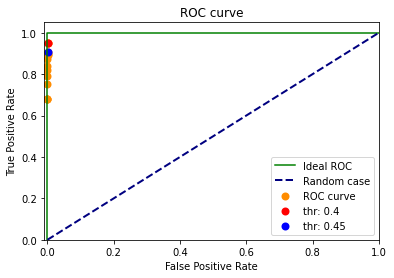

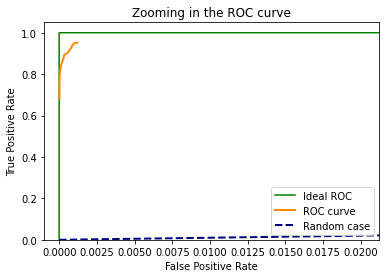

Threshold: 0.4 TAR: 0.9479423407274629 FAR 0.0009662984821680765
##############
ENCODINGS 50
FRAMES 120
MOD avg
#############


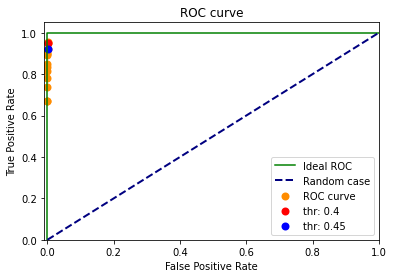

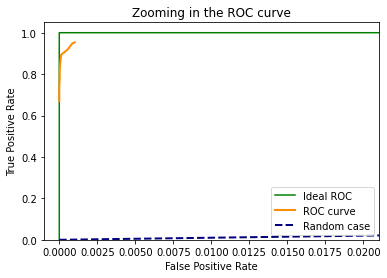

Threshold: 0.4 TAR: 0.9487639106729405 FAR 0.000862235568703822


In [0]:
base_log = root_path +"logs#11/"
dirs = os.listdir(base_log)
for d in dirs:
  
    folder = base_log + d +'/'
    e = d.split('_')[3]
    f = d.split('_')[4]
    t = d.split('_')[1]
    m = d.split('_')[5]
    if e == '-1':
      e = 'All'
    print("##############")
    print("ENCODINGS",e)
    print("FRAMES",f)
    print("MOD",m)
    print("#############")
   
    showStatsROC(folder)
    #_,_,_,_ = showStats(folder,d)

Comparing the logics, we could see that Fabrizio's experiment reach a lower FAR, penalising TAR. My logics instead can reach an higher TAR with the same encodings but it also makes more mistakes on FAR. Moreover, the strategy to pick sequential frames - as we did here - seems to be worse than taking random ones as we did in other case because frames close to each other have similar face characteristics.
Especially, we see that this encodings are often entirely discarded by the logics and they are not compared at all.